In [16]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_examples_all = train_data.iloc[:,1:] / 255.0
train_labels_all = train_data['label']
test_examples_all = test_data / 255.0

In [4]:
train_examples = np.asarray(train_examples_all.iloc[:35000,:], dtype=np.float32)
train_labels = np.asarray(train_labels_all.loc[:35000 - 1], dtype=np.int32)
validate_examples = np.asarray(train_examples_all.iloc[35000:,:], dtype=np.float32)
validate_labels = np.asarray(train_labels_all.loc[35000:], dtype=np.int32)
test_examples = np.asarray(test_examples_all, dtype=np.float32)

In [5]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_labels,
    batch_size=80,
    num_epochs=1,
    shuffle=True)

In [6]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_labels,
    num_epochs=1,
    shuffle=False)

In [7]:
validate_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':validate_examples},
    y=validate_labels,
    num_epochs=1,
    shuffle=False)

In [8]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_examples},
    num_epochs=1,
    shuffle=False)

In [9]:
def cnn_model_fn(features, labels, mode):
    
    reshape_layer_1 = tf.reshape(features['x'], [-1, 28, 28, 1])
    
    conv_layer_1 = tf.layers.conv2d(
        inputs=reshape_layer_1,
        filters=32,
        kernel_size=[10, 10],
        padding='same',
        activation=tf.nn.relu)
    
    conv_layer_2 = tf.layers.conv2d(
        inputs=conv_layer_1,
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)
    
    reshape_layer_2 = tf.reshape(conv_layer_2, [-1, 28 * 28 * 64])
    
    dense_layer = tf.layers.dense(
        inputs=reshape_layer_2,
        units=1024,
        activation=tf.nn.relu)
    
    is_train = False
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_train = True
        
    dropout_layer = tf.layers.dropout(
        inputs=dense_layer,
        rate=0.4,
        training=is_train)
    
    logits_layer = tf.layers.dense(
        inputs=dropout_layer,
        units=10)
    
    predictions = {
        'classes':tf.argmax(input=logits_layer, axis=1),
        'probabilities':tf.nn.softmax(logits_layer, name='softmax_tensor')}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(
        labels=labels,
        logits=logits_layer)
    
    accuracy = tf.metrics.accuracy(
        labels=labels,
        predictions = predictions['classes'],
        name='accu_op')
    
    tf.summary.scalar('accuracy', accuracy[1])
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_optimizer = tf.train.AdamOptimizer().minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)
    
    # mode = EVAL
    eval_metric_ops = {'accuracy':accuracy}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [10]:
# directory to periodically save weights, biases, acc, loss
OUTDIR = './cnn_mnist_train_data'

cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir=OUTDIR)

# call method to write train data to OUTDIR
file_writer = tf.summary.FileWriter(OUTDIR)

In [11]:
def train_and_evaluate(estimator, epochs=1):
    
    train_steps = 100
    total_steps = 20

    all_train_log = []
    all_validate_log = []
    
    for _ in range(epochs):
        
        for step in range(total_steps):
            
            estimator.train(input_fn=train_input_fn, steps=train_steps)
            
            train_log = estimator.evaluate(input_fn=eval_input_fn)
            print('STEP: {} of {}'.format(step, total_steps))
            print('TRAIN: acc={:.8f}\tloss={:.8f}'.format(train_log['accuracy'], train_log['loss']))
            
            validate_log = estimator.evaluate(input_fn=validate_input_fn)
            print('VALID: acc={:.8f}\tloss={:.8f}'.format(validate_log['accuracy'], validate_log['loss']))
            
            all_train_log.append(train_log)
            all_validate_log.append(validate_log)
            
    return all_train_log, all_validate_log

In [13]:
# TRAIN MODEL
train_log, validate_log = train_and_evaluate(cnn_classifier)

STEP: 0 of 20
TRAIN: acc=0.95088571	loss=0.15323599
VALID: acc=0.95128572	loss=0.15643163
STEP: 1 of 20
TRAIN: acc=0.97528571	loss=0.07862713
VALID: acc=0.97028571	loss=0.09130177
STEP: 2 of 20
TRAIN: acc=0.98420000	loss=0.05173963
VALID: acc=0.97799999	loss=0.06788591
STEP: 3 of 20
TRAIN: acc=0.98714286	loss=0.04285037
VALID: acc=0.97957140	loss=0.06275392
STEP: 4 of 20
TRAIN: acc=0.98634285	loss=0.04722067
VALID: acc=0.97957140	loss=0.06126892
STEP: 5 of 20
TRAIN: acc=0.99000001	loss=0.03281905
VALID: acc=0.98400003	loss=0.05487171
STEP: 6 of 20
TRAIN: acc=0.99131429	loss=0.02918881
VALID: acc=0.98371428	loss=0.05113395
STEP: 7 of 20
TRAIN: acc=0.99074286	loss=0.03290184
VALID: acc=0.98457146	loss=0.05077580
STEP: 8 of 20
TRAIN: acc=0.99262857	loss=0.02556741
VALID: acc=0.98657143	loss=0.04502760
STEP: 9 of 20
TRAIN: acc=0.99171430	loss=0.02703226
VALID: acc=0.98414284	loss=0.05217663
STEP: 10 of 20
TRAIN: acc=0.99059999	loss=0.03151440
VALID: acc=0.98085713	loss=0.06798695
STEP: 11 

In [14]:
train_acc = [i['accuracy'] for i in train_log]
valid_acc = [i['accuracy'] for i in validate_log]

train_loss = [i['loss'] for i in train_log]
valid_loss = [i['loss'] for i in validate_log]

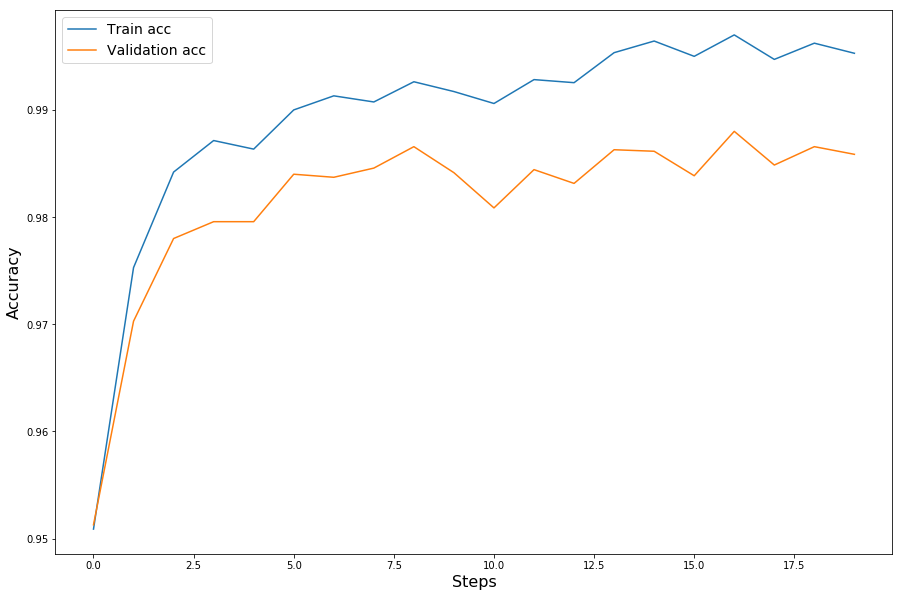

In [17]:
plt.figure(figsize=(15, 10))
plt.plot(train_acc)
plt.plot(valid_acc)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Steps', fontsize=16)
plt.legend(['Train acc', 'Validation acc'], fontsize=14, loc='upper left')
plt.show()

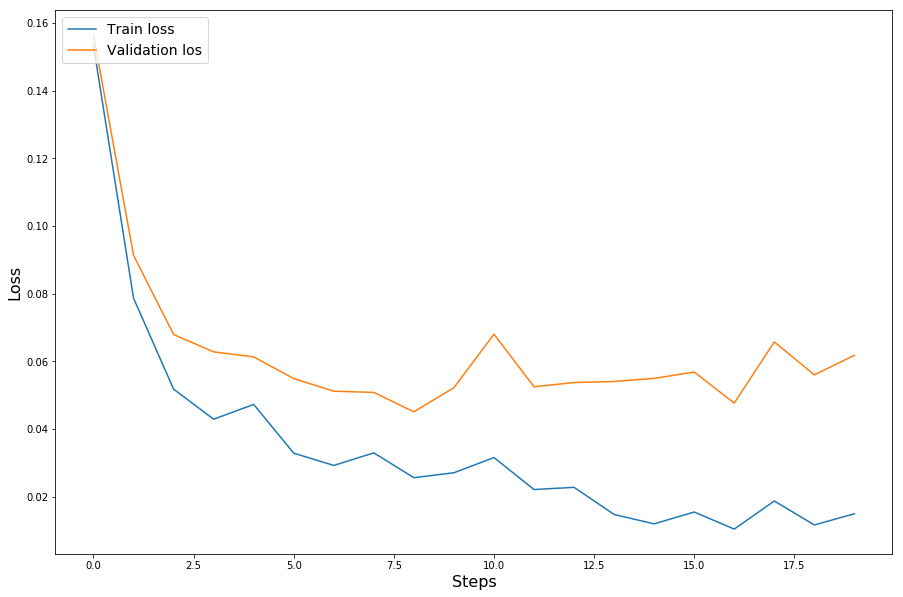

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Steps', fontsize=16)
plt.legend(['Train loss', 'Validation los'], fontsize=14, loc='upper left')
plt.show()

In [89]:
# create kaggle submission file
# in predict mode model returns generator
predict_generator = cnn_classifier.predict(input_fn=predict_input_fn)

# create list of dict like {class:class, probability:probability}
predict_dictlist = [next(predict_generator) for i in range(len(test_examples))]

# for kaggle we need only classes
classes = [predict_dictlist[item]['classes'] for item in range(len(predict_dictlist))]

# function to create pandas df
def create_mnist_submission_df(class_predictions, file_name):
    submission_df = pd.DataFrame()
    submission_df['ImageId'] = range(1, 28001, 1)
    submission_df['Label'] = class_predictions
    submission_df.set_index('ImageId', inplace=True)
    submission_df.to_csv(file_name)
    print('Saved predictions to ', file_name)

create_mnist_submission_df(classes, 'submission-01.csv')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./cnn_mnist_train_data/model.ckpt-5250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Saved predictions to  submission-01.csv
